In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

In [2]:
delta = pd.read_hdf('../_data/delta_Gmm_2pt5hours.h5')

In [3]:
y = dict()
energy = pd.DataFrame(columns = ["Year", "Regulation", "Vehicle", "kWh_in", "kWh_out", "kWh_cap", "cycles"])
year = 2019
v = "base"
for regulation in [False, True]:
    filename = 'Results/2019_base_1vehs_0.5gmm_2.5Gmm_Fine_65kpen_'\
              + str(regulation)\
              + '_regulation_True_robust_1_stages_noon_bid_time_True_symmetric.pickle'
    with open(filename, 'rb') as handle:
         b = pickle.load(handle)
            
    df = pd.DataFrame({'xb': b['vl'][v]['dec_soc'].xb, 
                   'xup': b['vl'][v]['dec_soc'].xup, 
                   'xdown': b['vl'][v]['dec_soc'].xdown, 
                   'd': b['vl'][v]['dec_soc'].d})
    
    df.fillna(0, inplace = True)
    
    TT = pd.date_range('01-01-2019 00:00:00', '12-31-2019 23:59:50', freq='10s') 
    df = df.reindex(index = TT, method='ffill')
    df['delta'] = delta.loc[TT, 'delta']
    df['y_grid'] = df.xb + np.maximum(df.delta, 0) * df.xdown - np.maximum(-df.delta, 0) * df.xup
    df['y_in'] = b['vl']['base']['nc'] * np.maximum(df.y_grid, 0)
    df['y_out'] = np.maximum(-df.y_grid, 0) / b['vl']['base']['nd']
    df['y'] = b['vl'][v]['y_star'] + np.cumsum(df.y_in - df.y_out - df.d) * 10 / 3600
    y[str(regulation)] = df['y']
    # Total SOC increase
    kWh_charged = df.y_in.sum() * 10/3600 
    kWh_discharged = (df.y_out.sum() + df.d.sum()) * 10/3600 
    energy.loc[len(energy.index)] = [year, regulation, v, 
                                 round(df.y_in.sum() * 10/3600,2),
                                 round((df.y_out.sum() + df.d.sum()) * 10/3600, 2),
                                 b['vl'][v]['y_max'] - b['vl'][v]['y_min'],
                                 round(( df.y_in.sum() * 10/3600 + (df.y_out.sum() + df.d.sum()) * 10/3600 ) /
                                 (2 * (b['vl'][v]['y_max'] - b['vl'][v]['y_min']) ),2)
                                ]

In [77]:
energy

Year  Regulation Vehicle   kWh_in  kWh_out  kWh_cap  cycles
0  2019       False    base  1987.95  1998.90     30.0   66.45
1  2019        True    base  2560.43  2561.91     30.0   85.37

In [86]:
df

xb       xup     xdown    d   delta    y_grid  \
2019-01-01 00:00:00  2.490494  3.020751  3.020751  0.0  0.0545  2.655125   
2019-01-01 00:00:10  2.490494  3.020751  3.020751  0.0  0.0370  2.602261   
2019-01-01 00:00:20  2.490494  3.020751  3.020751  0.0  0.0685  2.697415   
2019-01-01 00:00:30  2.490494  3.020751  3.020751  0.0  0.0915  2.766892   
2019-01-01 00:00:40  2.490494  3.020751  3.020751  0.0  0.0345  2.594710   
...                       ...       ...       ...  ...     ...       ...   
2019-12-31 23:59:10  0.000000  1.888112  1.888112  0.0  0.0865  0.163322   
2019-12-31 23:59:20  0.000000  1.888112  1.888112  0.0  0.1555  0.293601   
2019-12-31 23:59:30  0.000000  1.888112  1.888112  0.0  0.1445  0.272832   
2019-12-31 23:59:40  0.000000  1.888112  1.888112  0.0  0.1335  0.252063   
2019-12-31 23:59:50  0.000000  1.888112  1.888112  0.0  0.0980  0.185035   

                         y_in  y_out          y  
2019-01-01 00:00:00  2.256856    0.0  27.006269  
2019-01-01 00:00:10  2.211922    0.0  27.012413  
2019-01-01 00:00:20  2.292803    0.0  27.018782  
2019-01-01 00:00:30  2.351859    0.0  27.025315  
2019-01-01 00:00:40  2.205503    0.0  27.031442  
...                       ...    ...        ...  
2019-12-31 23:59:10  0.138823    0.0  25.515095  
2019-12-31 23:59:20  0.249561    0.0  25.515788  
2019-12-31 23:59:30  0.231907    0.0  25.516432  
2019-12-31 23:59:40  0.214254    0.0  25.517027  
2019-12-31 23:59:50  0.157280    0.0  25.517464  

[3153600 rows x 9 columns]

In [4]:
N = len(y['True'])
np.arange(1/(2*N), 1, 1/N)

array([1.58548960e-07, 4.75646880e-07, 7.92744800e-07, ...,
       9.99999207e-01, 9.99999524e-01, 9.99999841e-01])

In [6]:
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

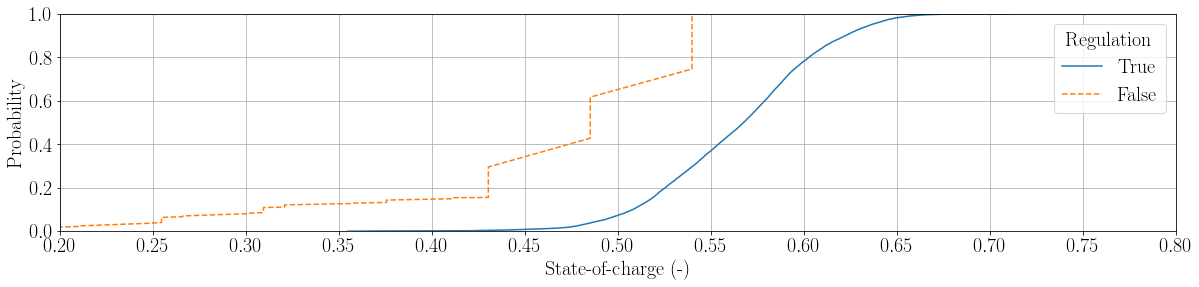

In [16]:
# daily_driving distance_base_random_weekends
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
fig = plt.figure(figsize=[20, 4])
plt.rcParams.update({'font.size': 20})

cap = 50 # battery capacity in kWh

plt.plot(y['True'].sort_values(ascending = True, ignore_index = True) / cap, np.arange(1/(2*N), 1, 1/N), label = 'True')
plt.plot(y['False'].sort_values(ascending = True, ignore_index = True) / cap, 
         np.arange(1/(2*N), 1, 1/N),
         linestyle = '--', label = 'False')
plt.grid()
plt.legend(title = "Regulation")
plt.ylim([0, 1])
plt.xticks(np.arange(0,1,0.05))
plt.xlim([0.2, 0.8])
plt.xlabel('State-of-charge (-)')
plt.ylabel('Probability')
plt.savefig("soc.pdf", bbox_inches = "tight")

In [18]:
print('Standard deviation from mid-point of state-of-charge *with* regulation: ' \
      + str( round(np.sqrt(np.sum((y['True'] - (b['vl'][v]['y_max'] + b['vl'][v]['y_min'])/2)**2)/N )/cap*100, 2)) + '%')

print('Standard deviation from mid-point of state-of-charge *without* regulation: ' \
      + str( round(np.sqrt(np.sum((y['False'] - (b['vl'][v]['y_max'] + b['vl'][v]['y_min'])/2)**2)/N )/cap*100, 2)) + '%')

Standard deviation from mid-point of state-of-charge *with* regulation: 7.88%
Standard deviation from mid-point of state-of-charge *without* regulation: 9.47%
